<a href="https://colab.research.google.com/github/AdaUchendu/TuringBench/blob/master/RoBERTa_Multinomial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load Data

In [ ]:
!pip install transformers==3.5.1
!pip install torch==1.4.0

     |████████████████████████████████| 1.3MB 5.1MB/s 
     |████████████████████████████████| 901kB 19.4MB/s 
     |████████████████████████████████| 2.9MB 14.6MB/s 
     |████████████████████████████████| 1.1MB 38.2MB/s 
     |████████████████████████████████| 753.4MB 24kB/s 
ERROR: torchvision 0.9.1+cu101 has requirement torch==1.8.1, but you'll have torch 1.4.0 which is incompatible.
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.4.0 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101


In [ ]:
!pip install datasets

Load Data

In [ ]:
import pandas as pd
import numpy as np
from datasets import load_datasets

In [ ]:
train = load_dataset('turingbench/TuringBench',name='AA', split='train')
train = pd.DataFrame.from_dict(train)

test = load_dataset('turingbench/TuringBench',name='AA', split='test')
test = pd.DataFrame.from_dict(test)

valid = load_dataset('turingbench/TuringBench',name='AA', split='valid')
valid = pd.DataFrame.from_dict(valid)

In [ ]:
list(train['label'].unique())

['gpt2_pytorch',
 'xlm',
 'xlnet_large',
 'ctrl',
 'grover_mega',
 'gpt1',
 'human',
 'gpt3',
 'grover_base',
 'fair_wmt20',
 'gpt2_large',
 'grover_large',
 'gpt2_medium',
 'pplm_distil',
 'xlnet_base',
 'pplm_gpt2',
 'gpt2_xl',
 'gpt2_small',
 'transfo_xl',
 'fair_wmt19']

In [ ]:
len(list(train['label'].unique()))

20

In [ ]:
def change_label(data):
  new_label = []
  for i in data['label']:
    
    if i == 'grover_base':
      new_label.append(0)
    elif i == 'grover_mega':
      new_label.append(1)
    elif i == 'grover_large':
      new_label.append(2)
    elif i == 'gpt1':
      new_label.append(3)
    elif i == 'gpt2_small':
      new_label.append(4)
    elif i == 'gpt2_medium':
      new_label.append(5)
    elif i == 'gpt2_large':
      new_label.append(6)
    elif i == 'gpt2_xl':
      new_label.append(7)
    elif i == 'gpt2_pytorch':
      new_label.append(8)
    elif i == 'ctrl':
      new_label.append(9)
    elif i == 'xlm':
      new_label.append(10)
    elif i == 'xlnet_base':
      new_label.append(11)
    elif i == 'xlnet_large':
      new_label.append(12)
    elif i == 'fair_wmt19':
      new_label.append(13)
    elif i == 'fair_wmt20':
      new_label.append(14)
    elif i == 'transfo_xl':
      new_label.append(15)
    elif i == 'pplm_distil':
      new_label.append(16)
    elif i == 'pplm_gpt2':
      new_label.append(17)
    elif i == 'gpt3':
      new_label.append(18)
    else:
      new_label.append(19)

  return pd.DataFrame({'text': data['text'], 'label': new_label})


In [ ]:
train = change_label(train)

In [ ]:
test = change_label(test)
valid = change_label(valid)

In [ ]:
train.head()

,text,label
0,took place in secret on a whim by the obama ad...,8
1,police hunt for suspect in four cases of rape ...,10
2,sundaram equity multiplier fund-dividend mutua...,12
3,it u+0092 s no show for cinepolis now the indi...,9
4,"springfield, ill. -- a factory owner now faces...",1


Classifier

In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [ ]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139657 entries, 0 to 139656
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    139657 non-null  object
 1   label   139657 non-null  object
dtypes: object(2)
memory usage: 3.2+ MB


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Text Generators')

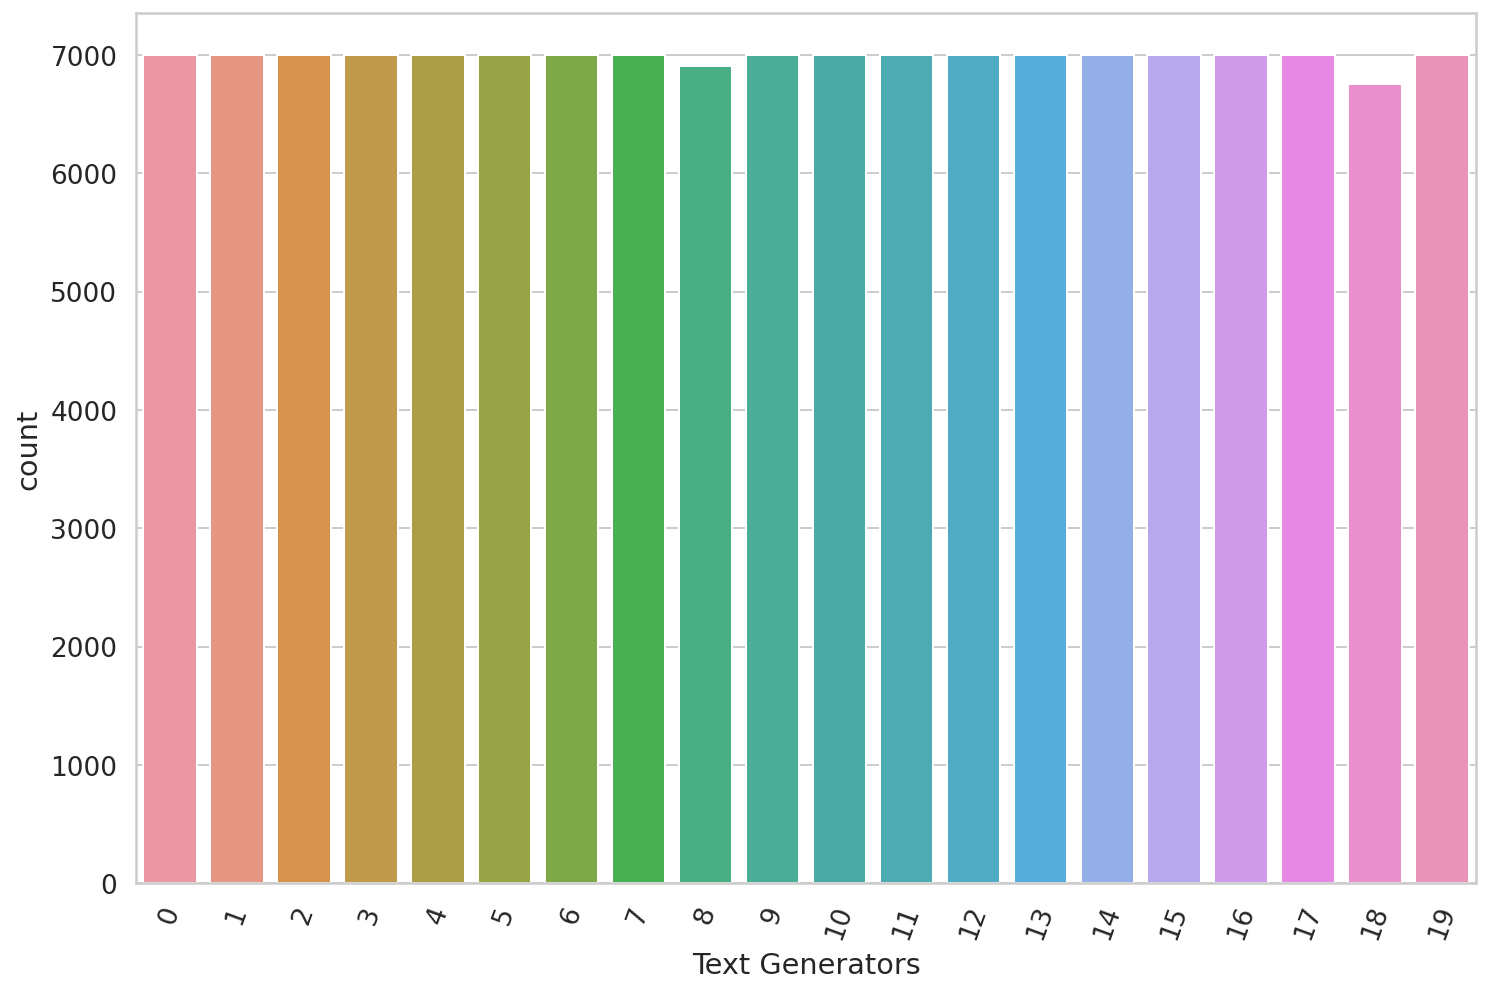

In [ ]:
sns.countplot(valid['label'])
plt.xticks(rotation=70)
plt.xlabel('Text Generators')

Data Processing

In [ ]:
from transformers import RobertaTokenizer, RobertaModel

In [ ]:
PRE_TRAINED_MODEL_NAME = 'roberta-base'  #'roberta-base-openai-detector' #'roberta-base'  # 

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
# token_lens = []
# for txt in train.text:
#   tokens = tokenizer.encode(txt, max_length=512)
#   token_lens.append(len(tokens))

In [ ]:
# sns.distplot(token_lens)
# plt.xlim([0, 600]);
# plt.xlabel('Token count');

In [ ]:
MAX_LEN = 400


Classifier

In [ ]:
class Text_Generation(Dataset):
  
  def __init__(self, text, label, tokenizer, max_len):
    self.text = text
    self.label = label
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.text)
  
  def __getitem__(self, item):
    review = str(self.text[item])
    target = self.label[item]
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    
    return {
      'text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'label': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
train.shape, valid.shape, test.shape

((139657, 2), (19953, 2), (39913, 2))

DataLoader

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  
  ds = Text_Generation(
    text=df.text.to_numpy(),
    label=df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(ds, batch_size=batch_size, num_workers=4, shuffle=True)

In [ ]:
BATCH_SIZE = 16


In [ ]:
train_data_loader = create_data_loader(train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(valid, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
train_data_loader.dataset.text[1]

'police hunt for suspect in four cases of rape minor girls the indian express - goa, gujarat /s 4. 5 : 00 pm ist / mumbai central -- delhi new york city ref name = india today ? ) ( hindi ; english & urdu and also punjabi or bengali with optional translation option only available here at cost! please check it out online from above link below section under languages # news @ edition _ language + article *... } { edit needed ~ comment no date none source unknown author unidentified writer anonymous publisher undisclosed place unnamed editor named person identified as journalist not yet published newspaper publication first day cover story headline about victim being raped by man accused murder case against him filed prosecutor arrested murderer tried again convicted killer executed sentence suspended verdict final judgement entered judgment read summary judge dismissed trial ended on appeal decision reversed jury acquitted defendant guilty found innocent condemned convict sentenced death

Bert Classifier

In [ ]:
# from transformers import AlbertForPreTraining

In [ ]:
# bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

bert_model = RobertaModel.from_pretrained(PRE_TRAINED_MODEL_NAME)


In [ ]:
class GeneratorClassifier(nn.Module):
  
  def __init__(self, n_classes):
    super(GeneratorClassifier, self).__init__()
    # self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.bert = RobertaModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
model = GeneratorClassifier(len(train['label'].unique()))
model = model.to(device)

In [ ]:
EPOCHS = 3 #10
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):

  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    label = d["label"].to(device)
    
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, label)
    correct_predictions += torch.sum(preds == label)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      label = d["label"].to(device)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask)
      
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, label)
      correct_predictions += torch.sum(preds == label)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)


In [ ]:
# %%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  
  train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(train))
  print(f'Train loss {train_loss} accuracy {train_acc}')
  
  val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, device, len(valid))
  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()
  
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'roberta_base_AA_finetuned.bin')
    best_accuracy = val_acc


Epoch 1/3
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Train loss 0.6734816262178206 accuracy 0.7075262965694523


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Val loss 0.5192743521064329 accuracy 0.760587380343808

Epoch 2/3
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Train loss 0.479449907951727 accuracy 0.7863551415253084


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Val loss 0.4771109476733284 accuracy 0.7994787751215356

Epoch 3/3
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Train loss 0.3902613997684747 accuracy 0.8288091538555175


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Val loss 0.4819090641461886 accuracy 0.8116072771011879



In [ ]:
# directory_path = '/content/drive/My Drive/TextGenerationAdaku/best_model_state.bin' ## we will store our data in this drive
# directory_path = '/content/drive/My Drive/TextGenerationAdaku/roberta_level1_model_state.bin'

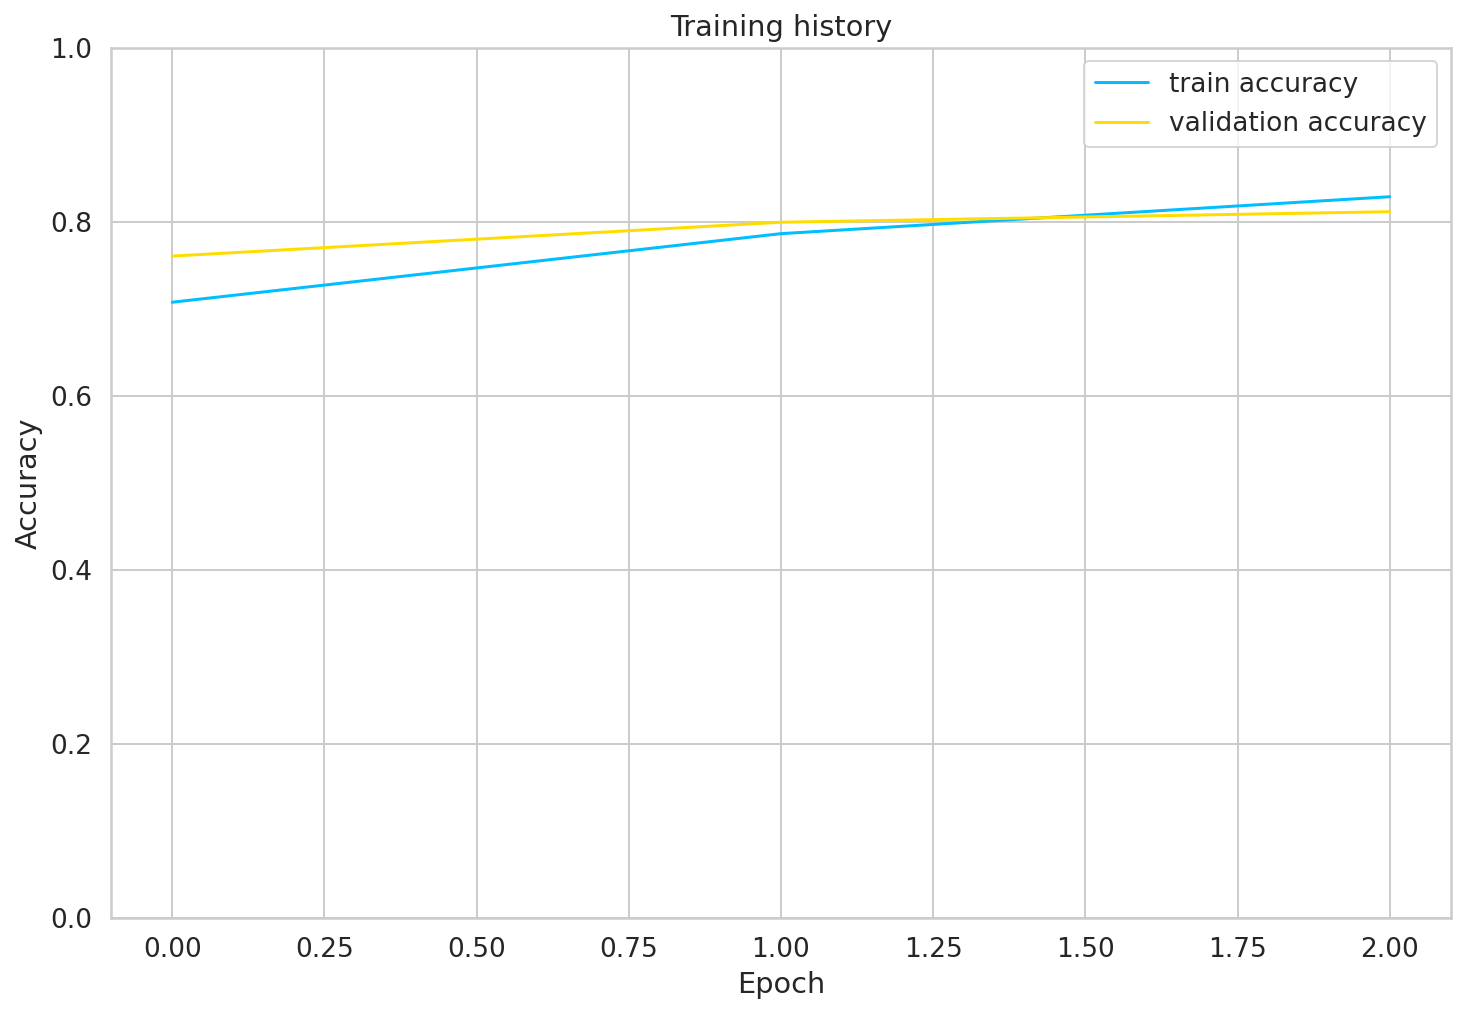

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(test)
)


test_acc.item()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0.8077318167013254

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  
  with torch.no_grad():
    for d in data_loader:
      texts = d["text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["label"].to(device)
      
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()

  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

In [ ]:
class_names = ['grover_base','grover_mega', 'grover_large','gpt1', 'gpt2_small','gpt2_medium', 'gpt2_large', 'gpt2_xl', 
               'gpt2_pytorch', 'ctrl', 'xlm', 'xlnet_base', 'xlnet_large', 'fair_wmt19', 'fair_wmt20', 'transfo_xl', 
               'pplm_distil', 'pplm_gpt2', 'gpt3', 'human']

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

 grover_base     0.7451    0.5353    0.6230      1999
 grover_mega     0.6013    0.6410    0.6205      2000
grover_large     0.4368    0.5253    0.4769      1999
        gpt1     1.0000    0.9975    0.9987      2000
  gpt2_small     0.5023    0.7580    0.6042      2000
 gpt2_medium     0.4134    0.4010    0.4071      2000
  gpt2_large     0.3738    0.3415    0.3569      2000
     gpt2_xl     0.5744    0.3360    0.4240      2000
gpt2_pytorch     0.9598    0.9827    0.9711      1969
        ctrl     0.9980    1.0000    0.9990      2000
         xlm     1.0000    0.9990    0.9995      2000
  xlnet_base     0.9854    0.9820    0.9837      2000
 xlnet_large     0.9955    0.9975    0.9965      2000
  fair_wmt19     0.9675    0.9520    0.9597      2000
  fair_wmt20     0.9406    0.9745    0.9573      2000
  transfo_xl     0.9970    0.9940    0.9955      2000
 pplm_distil     0.8537    0.9685    0.9075      2000
   pplm_gpt2     0.9338    

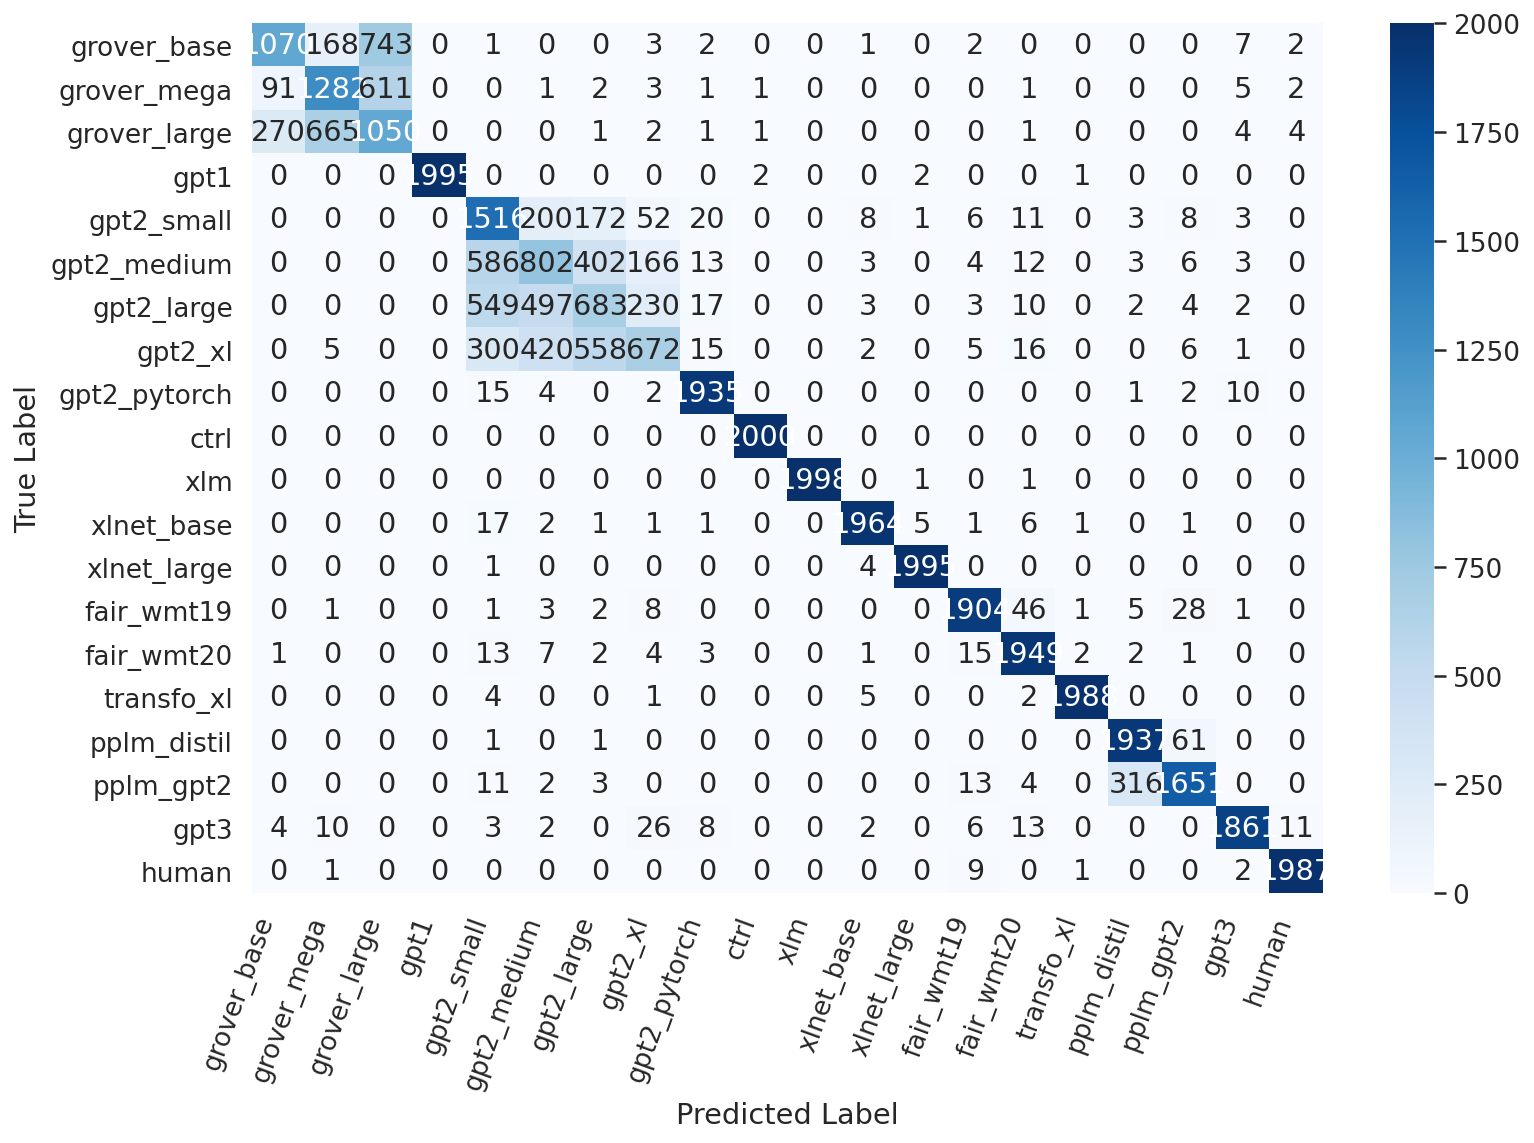

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=70, ha='right')
  
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
 # Code link 

# https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/